In [192]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime

class BacktestBase:
    '''Base Class for Event-Based Backtesting of trading strategies'''
    
    # Constructor Method
    def __init__(self, symbol, start, end, amount,
                 ftc=0.0, ptc=0.0, verbose = True):
        self.symbol = symbol
        self.start = start
        self.end = end 
        self.initial_amount = amount
        self.amount = amount
        self.ftc = ftc
        self.ptc = ptc
        self.units = 0 
        self.position = 0 
        self.trades = 0
        self.verbose = verbose
        self.get_data()
    
    # Data Retrieval Method
    def get_data(self):
        '''Retrieves data'''
        self.data = yf.download(self.symbol, start = self.start, end = self.end)
        if self.data.empty:
            print('No data pulled')

    def plot_data(self, cols=None):
        if cols is None:
            cols = ['Close']
        self.data['Close'].plot(figsize = (10,6), title = (f'A Graph of {self.symbol} Close Prices'))
    
    def get_date_price(self, bar):
        rawdate = pd.to_datetime(bar)
        
        if rawdate in self.data.index:
            price = self.data.loc[rawdate, 'Close']
            return str(rawdate.date()), price
        else:
            print(f"Date {rawdate} not found in data.")
        
    def print_balance(self, bar):
        '''Print out Current Cash Balance info'''
        date, price = self.get_date_price(bar)
        print(f'{date} | Current Balance: {self.amount:.2f}')

    def print_net_wealth(self, bar):
        '''Print out current net wealth info (current balance plus value of trading positions)'''
        date, price = self.get_date_price(bar)
        net_wealth = self.units * price + self.amount
        print(f'{date} | Current Net Wealth: {net_wealth:.2f}')

    # Core Methods
    def place_buy_order(self, bar, units=None, amount = None):
        '''Place a Buy order'''
        date, price = self.get_date_price(bar)
        if units is None:
            units = int(amount/price)
        total_cost = (units*price) * (1 + self.ptc) + self.ftc
        self.amount -= total_cost
        self.units += units
        self.position = 1
        self.trades += 1
        
        self.data.loc[bar, 'Inventory'] = self.units
        self.data.loc[bar, 'position'] = self.position        
        if self.verbose:
            print(f'{date} | Buying {units} at {price:.2f}')
            self.print_balance(bar)
            self.print_net_wealth(bar)
            print('=' * 55)

    def place_sell_order(self, bar, units=None, amount = None):
        '''Place a Sell order'''
        date, price = self.get_date_price(bar)
        if units is None:
            units = int(amount/price)
        total_revenue = (units*price) * (1 - self.ptc) - self.ftc
        self.amount += total_revenue
        self.units -= units
        self.position = 0
        if self.units <= 0:
            self.position = 0
            self.units = 0
        self.trades += 1
        self.data.loc[bar, 'Inventory'] = self.units
        self.data.loc[bar, 'position'] = self.position
        if self.verbose:
            print(f'{date} | Selling {units} at {price:.2f}')
            self.print_balance(bar)
            self.print_net_wealth(bar)
            print('=' * 55)
    
    def close_out(self, bar):
        '''Closing out positions at the end of the backtest period'''
        date, price = self.get_date_price(bar)
        self.amount += self.units * price
        self.units = self.units
        if self.verbose:
            print(f'{date} | inventory {self.units} units at {price:.2f}')
            print('=' * 55)
            print('Final balance [$] {:.2f}'.format(self.amount))
            perf = ((self.amount - self.initial_amount) /
                    self.initial_amount * 100)
            print('Net Performance [%] {:.2f}'.format(perf))
            print('Trades executed [#] {:.2f}'.format(self.trades))
            print('=' * 55)    
            

In [193]:
class BacktestEmaStrategy(BacktestBase):

    # Constructor Method
    def __init__(self, symbol, start, end, amount, EMA1, EMA2, ftc=0.0, ptc=0.0, verbose=True):  
        '''Backtesting an EMA crossover strategy.
        Parameters
        ==========
        symbol: str
            The stock symbol to backtest.
        start: str
            Start date for data retrieval.
        end: str
            End date for data retrieval.
        amount: float
            Initial amount of capital to use.
        EMA1: int
            Exponential Moving Average for shorter period.
        EMA2: int
            Exponential Moving Average for longer period.
        ftc: float
            Fixed transaction cost.
        ptc: float
            Proportional transaction cost.
        verbose: bool
            If True, print detailed output.
        '''
        super().__init__(symbol, start, end, amount, ftc, ptc, verbose)

        self.EMA1 = EMA1
        self.EMA2 = EMA2

        msg = f'\n\nRunning EMA Strategy | EMA1 = {self.EMA1} & EMA2 = {self.EMA2}'
        msg += f'\nFixed costs {self.ftc}'
        msg += f'\nProportional costs {self.ptc}'
        print(msg)
        print('=' * 55)
               
        self.calc_indicators()
        self.generate_signals()
        self.run_strategy()
        self.plot_chart()            

    def calc_indicators(self):
        ''''Calculate Technical Indicators'''
        self.data[f'EMA_{self.EMA1}'] = self.data.Close.ewm(span = self.EMA1, adjust = False).mean()
        self.data[f'EMA_{self.EMA2}'] = self.data.Close.ewm(span = self.EMA2, adjust = False).mean()
        self.data.dropna(inplace=True)   

    def generate_signals(self):
        '''Generate Trading Signals based upon technical indicators'''
        Indicator1 = f'EMA_{self.EMA1}'
        Indicator2 = f'EMA_{self.EMA2}'
        conditions = [(self.data[Indicator1] > self.data[Indicator2]), (self.data[Indicator1] <= self.data[Indicator2])]
        choices = [1,0]
        default = 0
        self.data['signal'] = np.select(conditions, choices, default=default)
        self.data.signal = self.data.signal.shift()
        self.data.dropna(inplace = True)
        
    def run_strategy(self):
        self.data['signal_change'] = self.data.signal - self.data.signal.shift()
        
        self.data['position'] = np.nan
        self.data['Inventory'] = np.nan
        self.data['Realized_Return'] = 0.0
        self.data['Unrealized_Return'] = 0.0
        self.data['Equity'] = np.nan
        self.buy_price = None
        self.data.loc[self.data['signal_change'] == 1, 'position'] = 1
        self.data.loc[self.data['signal_change'] == -1, 'position'] = 0
        self.data['position'] = self.data['position'].ffill().fillna(0)
        
        for bar in self.data.index:
            if self.data.loc[bar, 'signal_change'] == 1 and self.position == 0:
                self.place_buy_order(bar, amount=self.amount)
                self.buy_price = self.data.loc[bar, 'Close']

            elif self.data.loc[bar, 'signal_change'] == - 1 and self.position == 1: 
                sell_price = self.data.loc[bar, 'Close']
                realized_return = (sell_price - self.buy_price) * self.units
                self.place_sell_order(bar, units = self.units)
                self.data.loc[bar, 'Realized_Return'] = realized_return
                self.position = 0  
                self.units = 0
                self.data.loc[bar, 'Unrealized_Return'] = 0.0

            if self.position == 1:
                current_price = self.data.loc[bar, 'Close']
                unrealized_return = (current_price - self.buy_price) * self.units
                self.data.loc[bar, 'Unrealized_Return'] = unrealized_return
            else:
                self.data.loc[bar, 'Unrealized_Return'] = 0.0

            current_price = self.data.loc[bar, 'Close']
            self.data.loc[bar, 'Equity'] = self.amount + (self.units * current_price)
            self.data.loc[bar, 'Inventory'] = self.units
    
        self.close_out(self.data.index[-1]) 
        self.data['Inventory'] = self.data['Inventory'].ffill().fillna(0)     

    def plot_chart(self):
        Indicator1 = f'EMA_{self.EMA1}'
        Indicator2 = f'EMA_{self.EMA2}'
        plt.figure(figsize=(16,8))
        plt.plot(self.data.Close, color = 'black')
        plt.plot(self.data[Indicator1], color = 'blue', label = 'EMA 11')
        plt.plot(self.data[Indicator2], color = 'orange', label = 'EMA 22')
        buy_signals = self.data[self.data['signal_change'] == 1]
        sell_signals = self.data[self.data['signal_change'] == -1]

        plt.scatter(buy_signals.index, buy_signals['Close'], marker='^', color='g', label='Buy Signal', s=100)
        plt.scatter(sell_signals.index, sell_signals['Close'], marker='v', color='r', label='Sell Signal', s=100)
        plt.xlabel('Date')
        plt.ylabel('Closing Price')
        plt.title(f'EMA Cross Over Strategy for {self.symbol}')
        plt.grid()
        plt.legend()
  
                        
    

[*********************100%%**********************]  1 of 1 completed



Running EMA Strategy | EMA1 = 11 & EMA2 = 22
Fixed costs 0.0
Proportional costs 0.0
2024-01-08 | Buying 191 at 52.25
2024-01-08 | Current Balance: 19.68
2024-01-08 | Current Net Wealth: 10000.00
2024-04-18 | Selling 191 at 84.67
2024-04-18 | Current Balance: 16191.84
2024-04-18 | Current Net Wealth: 16191.84
2024-05-07 | Buying 178 at 90.55
2024-05-07 | Current Balance: 73.23
2024-05-07 | Current Net Wealth: 16191.84
2024-07-25 | Selling 178 at 112.28
2024-07-25 | Current Balance: 20059.07
2024-07-25 | Current Net Wealth: 20059.07
2024-08-19 | Buying 154 at 130.00
2024-08-19 | Current Balance: 39.07
2024-08-19 | Current Net Wealth: 20059.07
2024-09-05 | Selling 154 at 107.21
2024-09-05 | Current Balance: 16549.41
2024-09-05 | Current Net Wealth: 16549.41
2024-09-09 | inventory 0 units at 106.47
Final balance [$] 16549.41
Net Performance [%] 65.49
Trades executed [#] 6.00


<bound method BacktestBase.plot_data of <__main__.BacktestEmaStrategy object at 0x000001D97B9A4FE0>>

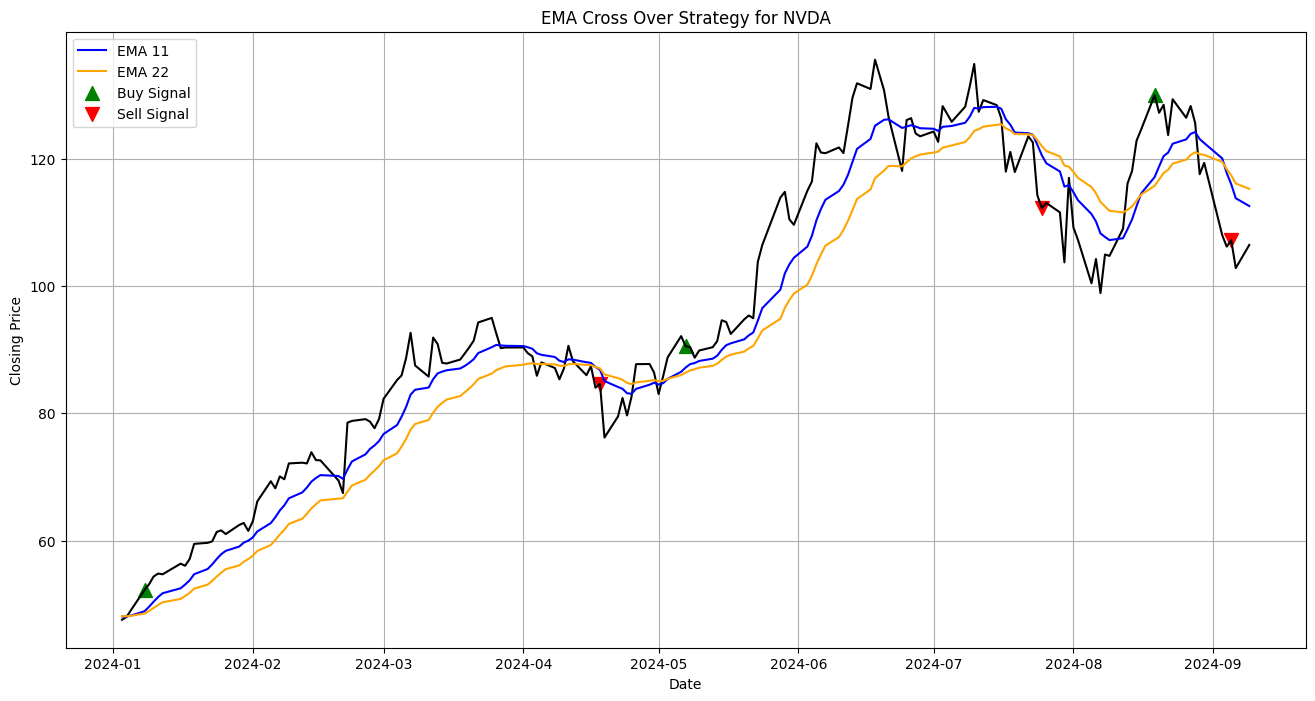

In [195]:
if __name__ == "__main__":
    instance = BacktestEmaStrategy(symbol="NVDA", start="2024-01-01", end = "2024-09-10", amount=10000, EMA1=11, EMA2=22)

view = instance.data
instance.plot_data

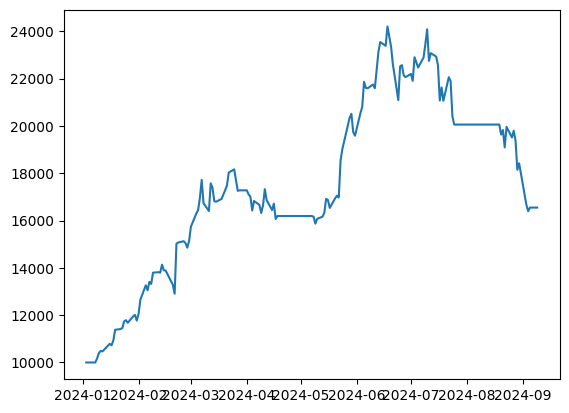

In [198]:
plt.plot(instance.data['Equity'])